In [2]:
import tensorflow as tf

tf.config.list_physical_devices(device_type=None)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

# Data science libraries
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
# import cupy as cp
import pandas as pd
from tensorflow.keras import backend as K, Input, Model, optimizers

# Others
from IPython.core.debugger import set_trace
from pathlib import Path
import os

import tcn_ed
from tcn_ed import TCN, tcn_full_summary, compiled_tcn
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.metrics
from tensorflow.keras import mixed_precision
from tensorflow.keras.metrics import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.activations import swish
tf.debugging.set_log_device_placement(False)
from __future__ import absolute_import, division, print_function
import datetime
import time

from timeit import default_timer as timer
from sklearn import metrics
from help_pre import create_data_batcht as Create_Batch, create_pred_batch

tf.config.list_physical_devices(device_type=None)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

visible_devices = tf.config.get_visible_devices()
print(visible_devices)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

K.backend()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


'tensorflow'

In [3]:
working_dir = Path('.')
DATA1_PATH = Path("./Datatest")
DATA_PATH = Path("./Datatest/CWRU")
save_model_path = working_dir / 'Model' 
DE_path = DATA_PATH / '12DriveEndFault'
DE_path1 = DE_path / '1730'
DE_path2 = DE_path / '1750'
DE_path3 = DE_path / '1772'
DE_path4 = DE_path / '1797'

FE_path = DATA_PATH / '12FanEndFault'
FE_path1 = FE_path / '1730'
FE_path2 = FE_path / '1750'
FE_path3 = FE_path / '1772'
FE_path4 = FE_path / '1797'

DE48_path = DATA_PATH / '48DriveEndFault'
DE48_path1 = DE48_path / '1730'
DE48_path2 = DE48_path / '1750'
DE48_path3 = DE48_path / '1772'
DE48_path4 = DE48_path / '1797'

Normal_path = DATA_PATH / 'NormalBaseline'
Normal_path1 = Normal_path / '1730'
Normal_path2 = Normal_path / '1750'
Normal_path3 = Normal_path / '1772'
Normal_path4 = Normal_path / '1797'

val_path = DATA1_PATH / 'for_pred'
val_DE_path = val_path / '12DriveEndFault'
val_DE_path1 = val_DE_path / '1730'
val_DE_path2 = val_DE_path / '1750'
val_DE_path3 = val_DE_path / '1772'
val_DE_path4 = val_DE_path / '1797'

val_FE_path = val_path / '12FanEndFault'
val_FE_path1 = val_FE_path / '1730'
val_FE_path2 = val_FE_path / '1750'
val_FE_path3 = val_FE_path / '1772'
val_FE_path4 = val_FE_path / '1797'

val_DE48_path = val_path / '48DriveEndFault'
val_DE48_path1 = val_DE48_path / '1730'
val_DE48_path2 = val_DE48_path / '1750'
val_DE48_path3 = val_DE48_path / '1772'
val_DE48_path4 = val_DE48_path / '1797'

val_Normal_path = val_path / 'NormalBaseline'
val_Normal_path1 = val_Normal_path / '1730'
val_Normal_path2 = val_Normal_path / '1750'
val_Normal_path3 = val_Normal_path / '1772'
val_Normal_path4 = val_Normal_path / '1797'


val_path = [val_DE_path1, val_DE_path2, val_DE_path3, val_DE_path4, val_Normal_path4]

#Paths = [DE_path1, DE_path2, DE_path3, DE_path4, FE_path1, FE_path2, FE_path3, FE_path4, DE48_path1, DE48_path2,  DE48_path4, Normal_path1, Normal_path2, Normal_path3, Normal_path4]
Paths = [DE_path1, DE_path2, DE_path3, DE_path4, FE_path1, FE_path2, FE_path3, FE_path4, Normal_path1, Normal_path2, Normal_path3, Normal_path4]#, DE48_path1, DE48_path2,  DE48_path4]
Pathsde = [DE_path1, DE_path2, DE_path3, DE_path4, Normal_path1, Normal_path2, Normal_path3, Normal_path4]
Paths48 = [DE_path1, DE_path2, DE_path3, DE_path4, FE_path1, FE_path2, FE_path3, FE_path4, Normal_path1, Normal_path2, Normal_path3, Normal_path4, DE48_path1, DE48_path2,  DE48_path4]
data_path = Paths

#segment_length = 2400 # The length of the window used to take sub-arrays from each file
#step_size = 300 # the amount the window moves along the sub-array
split_perc = 0.4 # percentage of data to put towards the test set
#b_size = 1024
#b_size1 = int(b_size*2)
#b_size2 = int(b_size / 4)

#step_length = step_size

for path in [DATA_PATH, save_model_path]:
    if not path.exists():
        path.mkdir(parents=True)
        
data_path = Paths

In [4]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [5]:

class TimedStopping(Callback):
    '''Stop training when enough time has passed.
    # Arguments
        seconds: maximum time before stopping.
        verbose: verbosity mode.
    '''
    def __init__(self, seconds=None, verbose=0):
        super(Callback, self).__init__()

        self.start_time = 0
        self.seconds = seconds
        self.verbose = verbose

    def on_train_begin(self, logs={}):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        if time.time() - self.start_time > self.seconds:
            self.model.stop_training = True
            if self.verbose:
                print('Stopping after %s seconds.' % self.seconds)

In [6]:
class TimeStopping(Callback):
    """Stop training when a specified amount of time has passed.
    Args:
        seconds: maximum amount of time before stopping.
            Defaults to 86400 (1 day).
        verbose: verbosity mode. Defaults to 0.
    """

    def __init__(self, seconds=9000, verbose=0):
        super(TimeStopping, self).__init__()

        self.seconds = seconds
        self.verbose = verbose

    def on_train_begin(self, logs=None):
        self.stopping_time = time.time() + self.seconds

    def on_epoch_end(self, epoch, logs={}):
        if time.time() >= self.stopping_time:
            self.model.stop_training = True
            self.stopped_epoch = epoch

    def on_train_end(self, logs=None):
        if self.verbose > 0 and time.time() >= self.stopping_time:
            formatted_time = datetime.timedelta(seconds=self.seconds)
            msg = 'Timed stopping at epoch {} after training for {}'.format(
                self.stopped_epoch + 1, formatted_time)
            print(msg)

    def get_config(self):
        config = {
            'seconds': self.seconds,
            'verbose': self.verbose,
        }

        base_config = super(TimeStopping, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [13]:


def adjust_dilations(dilations: list):
    if all([is_power_of_two(i) for i in dilations]):
        return dilations
    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations

#def accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            #if K.ndim(y_true) == K.ndim(y_pred):
                #y_true = K.squeeze(y_true, -1)
            # convert dense predictions to labels
            #y_pred_labels = K.argmax(y_pred, axis=-1)
            #y_pred_labels = K.cast(y_pred_labels, K.floatx())
            #return K.cast(K.equal(y_true, y_pred_labels), K.floatx())
        
def pred_accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            # convert dense predictions to labels
            y_pred_labels = K.cast(y_pred, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

def create_model(num_feat,
                 num_classes,
                 filt_num,
                 kernel_num,
                 stack, dilation,
                 lr,
                 drop_rate,
                 segment_length,
                 use_skip,
                 opt):




    with mirrored_strategy.scope():
        #x =Sequential()

        
        input_layer = Input(shape=(segment_length, num_feat))

        def get_opt():
            if opt == 'adam':
                return optimizers.Adam(lr=lr)
            elif opt == 'rmsprop':
                return optimizers.RMSprop(lr=lr)
            else:
                raise Exception('Only Adam and RMSProp are available here')
            
        x = TCN(nb_filters=filt_num,
                kernel_size=kernel_num,
                nb_stacks=stack,
                dilations=[2 ** i for i in range(dilation)],
                padding='causal',
                use_skip_connections=use_skip,
                dropout_rate=drop_rate,
                return_sequences=False,
                activation='swish', 
                kernel_initializer='he_uniform',
                use_batch_norm=True,
                use_layer_norm=False,
                use_weight_norm=False,
                name='Model')(input_layer)

        tcn = TCN(nb_filters=filt_num,
                  kernel_size=kernel_num,
                  nb_stacks=stack,
                  dilations=[2 ** i for i in range(dilation)],
                  padding='causal',
                  use_skip_connections=use_skip,
                  dropout_rate=drop_rate,
                  return_sequences=False,
                  activation='swish', 
                  kernel_initializer='he_uniform',
                  use_batch_norm=True,
                  use_layer_norm=False,
                  use_weight_norm=False,
                  name='Model')

        print('Receptive Field Size: %s' % tcn.receptive_field)



        print('x.shape=', x.shape)


        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax', dtype='float32')(x)
        output_layer = x
        model = Model(input_layer, output_layer)

        # https://github.com/keras-team/keras/pull/11373
        # It's now in Keras@master but still not available with pip.
        # TODO remove later.

    with mirrored_strategy.scope():
        model.compile(get_opt(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy']) #, callbacks=my_callbacks)

        print('model.x = {}'.format(input_layer.shape))
        print('model.y = {}'.format(output_layer.shape))

        print('Filter Length: %s' % filt_num)
        print('Kernel Size: %s' % kernel_num)
        print('Dilation: %s' % dilation)
        print('Learning Rate: %s' % lr)
        print('Dropout Rate: %s' % drop_rate)

        model.summary()


        return model

def train_func(train_data,
               test_dataset,
               Val_dataset,
               predict_labels,
               segment_length,
               runs,
               filt_num,
               kernel_num,
               dilation,
               stack,
               learn_r,
               drop_rate,
               Model_num):
    
    
        
    time1 = timer()
        
    working_dir = Path('.')
    model_path = working_dir / 'Model' / ('Model_{}_k{}_s{}_di{}_dr{}_L{}'.format(Model_num, kernel_num, stack, dilation, drop_rate, segment_length))
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        save_weights_only=True,
        monitor='sparse_categorical_accuracy',
        mode='max',
        save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.3,   
                                  patience=4, 
                                  min_lr=0.00000015,
                                  verbose=0, 
                                  cooldown=5)

    ES_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             min_delta=0.0000001, 
                                             patience=60, 
                                             verbose=0, 
                                             mode='auto', 
                                             baseline=None, 
                                             restore_best_weights=True)
    
    timer_cb = TimeStopping(seconds=9000, verbose=0)

    # to load best weights model.load_weights(latest)

    callback = [reduce_lr, ES_cb, cp_callback, timer_cb]
    #seg_length = None
    time_out = timer()-time1
    print('Time till start of create model %s' % time_out)
    time2 = timer()
    model = create_model(num_feat=1,
                         num_classes=4,
                         filt_num=filt_num,
                         kernel_num=kernel_num,
                         stack=stack,
                         dilation=dilation,
                         lr=learn_r,
                         drop_rate=drop_rate,
                         segment_length = segment_length,
                         use_skip=True,
                         opt='adam')

    time3 = timer()
    time_out = time3-time2
    print('Time to create model %s' % time_out)
    with mirrored_strategy.scope():
        history = model.fit(train_data,
                  epochs=runs,
                  verbose=2,
                  callbacks=callback,
                  validation_data=test_dataset)
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.show()
    plt.plot(history.history['loss'])
    plt.show()
    time_out = timer()-time3
    print('Time to fit model %s' % time_out)
    with mirrored_strategy.scope():
        y_preds = model.predict(Val_dataset,
                                       verbose=1,
                                       callbacks=callback,
                                      )
        y_argmax2 = np.argmax(y_preds,axis=1)
        predict_labels = np.squeeze(predict_labels[:], axis=1)
        #for pred1, pred2, pred3, pred4 in y_pred:
        #y_argmax = []
        #i=0
        perc_score = tf.dtypes.cast((sum(pred_accuracy(predict_labels, y_argmax2))/(len(predict_labels))), tf.float16)
        Accuracy_test = float(perc_score)
        print('Prediction Accuracy: %s' % Accuracy_test)
        con_mat = metrics.confusion_matrix(predict_labels, y_argmax2)
        class_report = metrics.classification_report(predict_labels, y_argmax2, digits=3)
        print(con_mat, '\n\n')
        print(class_report, '\n\n')
    
    

    
    d = {'segment length':[segment_length], 'filters': [filt_num], 'kernel size': [kernel_num], 'stacks':[stack], 'dropout': [drop_rate], 'lr': [learn_r], 'dilation': [dilation], 'Training Time': time_out, 'train loss': [history.history['loss'][-1]], 'train acc': [history.history['sparse_categorical_accuracy'][-1]], 'eval acc': [history.history['val_sparse_categorical_accuracy'][-1]], 'Eval Acc': [Accuracy_test],'C1 correct': [con_mat[0][0]], 'C1 as C2':[con_mat[0][1]], 'C1 as C3':[con_mat[0][2]], 'C1 as C4':[con_mat[0][3]],'C2 as C1': [con_mat[1][0]], 'C2 correct':[con_mat[1][1]], 'C2 as C3':[con_mat[1][2]], 'C2 as C4':[con_mat[1][3]],'C3 as C1': [con_mat[2][0]], 'C3 as C2':[con_mat[2][1]], 'C3 correct':[con_mat[2][2]], 'C3 as C4':[con_mat[2][3]],'C4 as C1': [con_mat[3][0]], 'C4 as C2':[con_mat[3][1]], 'C4 as C3':[con_mat[3][2]], 'C4 correct':[con_mat[3][3]]}
    
    
    append_list2_in = pd.DataFrame.from_dict(d)
    
    #append_list2_in.to_csv(r'{}.csv'.format(model_path), index = False, header=['filters', 'kernel size', 'dropout', 'lr', 'dilation','Training Time', 'train loss', 'train acc', 'eval acc','Eval Acc','C1 correct', 'C1 as C2', 'C1 as C3', 'C1 as C4','C2 as C1', 'C2 correct', 'C2 as C3', 'C2 as C4','C3 as C1', 'C3 as C2', 'C3 correct', 'C3 as C4','C4 as C1', 'C4 as C2', 'C4 as C3', 'C4 correct'])
    #Csv_list = []
    #Csv_list.append('Loss: %s , Acc: %s , Prediction Accuracy: %s , Confusion Matrix: %s , Classification Report: %s' % (history.history['loss'][-1], history.history['sparse_categorical_accuracy'][-1], Accuracy_test, con_mat, class_report))
    
    time_out = timer()-time1
    print('Total Time %s' % time_out)
    
    return history, y_preds, append_list2_in


In [8]:
Learning_Rate = 0.0125
Drop_rate = 0.3
Repeats = 100

In [9]:
b_size = 1024
b_size2 = int(b_size / 4)
step_size = 300
segment_length = 4000
with mirrored_strategy.scope():
    train_dataset, test_dataset, train_count, test_count = Create_Batch(data_path, split_perc, segment_length=segment_length, step_length=step_size, b_size=b_size)


class balance of train frame: 3    19246
2    11386
1    10613
0     4804
Name: label, dtype: int64
class balance of test frame: 3    15334
1     6675
0     6416
2     5100
Name: label, dtype: int64


In [10]:
with mirrored_strategy.scope():
    Val_dataset, predict_labels, val_count = create_pred_batch(val_path, segment_length, step_length=step_size, b_size=b_size2)

class balance of val frame: 3    2366
0    1600
1    1572
2     786
Name: label, dtype: int64


In [11]:
print("num")

num


In [13]:
Learning_Rate = 0.0125
Drop_rate = 0.3
Repeats = 100

Model Number 0
Time till start of create model 0.00024323999969055876
Receptive Field Size: 2541
x.shape= (None, 16)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
model.x = (None, 4096, 1)
model.y = (None, 4)
Filter Length: 16
Kernel Size: 11
Dilation: 7
Learning Rate: 0.0125
Dropout Rate: 0.3
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4096, 1

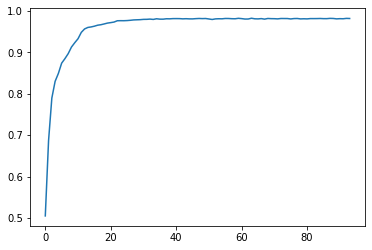

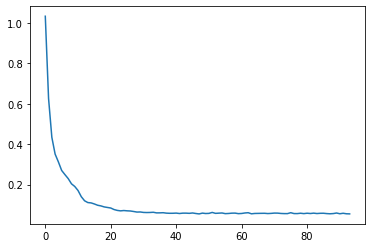

Time to fit model 2519.995712768996
29/29 [==============================] - 8s 80ms/step
Prediction Accuracy: 0.9560546875
[[1874    0    0    0]
 [   2 1519    2  317]
 [   0    0  920    0]
 [   0    1    3 2764]] 


              precision    recall  f1-score   support

           0      0.999     1.000     0.999      1874
           1      0.999     0.826     0.904      1840
           2      0.995     1.000     0.997       920
           3      0.897     0.999     0.945      2768

    accuracy                          0.956      7402
   macro avg      0.972     0.956     0.962      7402
weighted avg      0.960     0.956     0.955      7402
 


Total Time 2530.415923501001


In [14]:

m_count = 0
print('Model Number %s' % m_count)
append_list_time1 = pd.DataFrame()
with mirrored_strategy.scope():
    history, y_preds, res_list = train_func(train_data=train_dataset,
                                            test_dataset=test_dataset,
                                            Val_dataset=Val_dataset,
                                            predict_labels=predict_labels, 
                                            filt_num=16,
                                            kernel_num=11,
                                            dilation=7,
                                            stack=1,
                                            learn_r=Learning_Rate,
                                            drop_rate=Drop_rate,
                                            runs=Repeats,
                                            Model_num = m_count, 
                                            segment_length = segment_length)

append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
tf.keras.backend.clear_session()

In [11]:
Learning_Rate = 0.0125
Drop_rate = 0.3
Repeats = 100

In [ ]:

m_count = 0
print('Model Number %s' % m_count)
append_list_time1 = pd.DataFrame()
with mirrored_strategy.scope():
    history, y_preds, res_list = train_func(train_data=train_dataset,
                                            test_dataset=test_dataset,
                                            Val_dataset=Val_dataset,
                                            predict_labels=predict_labels, 
                                            filt_num=16,
                                            kernel_num=11,
                                            dilation=7,
                                            stack=1,
                                            learn_r=Learning_Rate,
                                            drop_rate=Drop_rate,
                                            runs=Repeats,
                                            Model_num = m_count, 
                                            segment_length = segment_length)

append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
tf.keras.backend.clear_session()

Model Number 0
Time till start of create model 0.00023112000053515658
Receptive Field Size: 2541
x.shape= (None, 16)
model.x = (None, 4000, 1)
model.y = (None, 4)
Filter Length: 16
Kernel Size: 11
Dilation: 7
Learning Rate: 0.0125
Dropout Rate: 0.3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4000, 1)]         0         
_________________________________________________________________
Model (TCN)                  (None, 16)                37936     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 38,004
Trainable params: 37,556
Non-trainable params: 448
_________________________________________________________________
Ti

In [49]:
append_list_time1.sort_values(by=['segment length', 'kernel size', 'stacks', 'dilation', 'filters'], ascending=[True, False, False, False, True])
append_list_time1.to_csv(r'{}.csv'.format('List_Check_300'), index = False, header=['segment length', 'filters', 'kernel size', 'stacks', 'dropout', 'lr', 'dilation','Training Time', 'train loss', 'train acc', 'eval acc','Eval Acc','C1 correct', 'C1 as C2', 'C1 as C3', 'C1 as C4','C2 as C1', 'C2 correct', 'C2 as C3', 'C2 as C4','C3 as C1', 'C3 as C2', 'C3 correct', 'C3 as C4','C4 as C1', 'C4 as C2', 'C4 as C3', 'C4 correct'])

In [46]:
append_list_time1

,segment length,filters,kernel size,stacks,dropout,lr,dilation,Training Time,train loss,train acc,...,C2 as C3,C2 as C4,C3 as C1,C3 as C2,C3 correct,C3 as C4,C4 as C1,C4 as C2,C4 as C3,C4 correct
0,2400,16,6,2,0.175,0.0125,7,659.189826,0.055559,0.981654,...,1,80,0,0,200,0,0,0,29,270
1,2400,32,6,2,0.175,0.0125,7,1619.093654,0.013442,0.995525,...,2,1,0,0,200,0,0,0,0,299
2,2400,64,6,2,0.175,0.0125,7,3123.541723,0.018711,0.993533,...,5,0,0,0,200,0,0,18,0,281
3,2400,16,6,1,0.175,0.0125,8,623.930027,0.049244,0.984067,...,0,3,0,0,191,9,0,0,17,282
4,2400,32,6,1,0.175,0.0125,8,638.345629,0.026409,0.990862,...,1,7,0,0,200,0,0,0,22,277
5,2400,64,6,1,0.175,0.0125,8,1099.084539,0.016896,0.994494,...,0,0,0,0,200,0,0,1,5,293
6,2400,16,11,1,0.175,0.0125,7,421.807514,0.022398,0.992994,...,1,2,0,0,200,0,0,0,1,298
7,2400,32,11,1,0.175,0.0125,7,562.381346,0.011449,0.996275,...,2,1,0,1,199,0,0,0,4,295
8,2400,64,11,1,0.175,0.0125,7,1392.870528,0.076700,0.971087,...,8,8,0,0,200,0,0,3,0,296
9,3600,16,8,1,0.175,0.0125,8,642.300958,0.012497,0.996116,...,7,0,0,0,132,0,0,0,0,199


# Save and Reload Model